In [ ]:
import pandas as pd

#load dataset
df = pd.read_csv('loan-data.csv')

## Table of Contents

*Note: The estimated time to execute this exercise is approximately 22-25 minutes, primarily during the model training phase (Section 5). Look for the light execution.*

1. Business Problem Definition
2. Data Preparation and Train-Test Split
   - 2.1 Exploratory Data Analysis
   - 2.2 Feature Engineering Considerations
3. Preprocessing Pipeline Architecture
   - 3.1 Imputation Strategy
   - 3.2 Encoding Strategy
   - 3.3 Scaling Strategy: Dual Preprocessor Approach
   - 3.4 Pipeline Design and Sequential Processing
   - 3.5 Outlier Analysis and Handling Strategy
4. Model Selection and Hyperparameter Grid Design
   - 4.1 Linear Models
   - 4.2 Tree-Based Models
   - 4.3 Gradient Boosting Models
   - 4.4 Support Vector Machine
   - 4.5 Probabilistic Model
   - 4.6 Cross-Validation Strategy
   - 4.7 Hyperparameter Search Space Justification
5. Grid Search Execution and Model Training
6. Performance Analysis and Model Evaluation
   - 6.1 Cross-Validation Performance Analysis
   - 6.2 Training Time Analysis
   - 6.3 Overfitting Detection
   - 6.4 Test Set Evaluation and Final Model Assessment
   - 6.5 Comprehensive Model Comparison on Test Set
   - 6.6 Precision-Recall Trade-off Analysis
7. Business Impact and Metric Justification

### Imports

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import (confusion_matrix, recall_score,precision_score, f1_score, roc_auc_score, average_precision_score)
import matplotlib.pyplot as plt

from sklearn import set_config
set_config(transform_output="pandas")
import warnings
warnings.filterwarnings('ignore')

### 1. Business Problem Definition and Primary Metric

**Context:** The target variable `loan_status` represents whether the bank approved (1) or rejected (0) each loan application. The variable reflects the bank's decision-making process. Manually approving loans is a time-consuming process which offers the potential to be improved through our machine learning solution.

**Objective:** We will predict the bank's loan approval decisions. The goal is to automate routine approvals while maintaining the bank's established (historical) lending standards.

**Why predict "loan_status"? - Potential Business Benefits:**
1. **Automate routine decisions** - Provide instant approvals/rejections for clear-cut applications
2. **Reduce processing time** - Cut decision time from days to seconds for obvious cases
3. **Ensure consistency** - Replicate the bank's historical lending criteria uniformly across all branches and applications.

### 1.2 Primary Metric

We select **PRECISION** as our optimization target.

Precision = TP / (TP + FP) quantifies the reliability of our auto-approvals. By maximizing precision, we minimize false positives cases where the system approves applications the bank would reject, potentially violating established risk criteria.

**Why Precision Over Recall:**

*Asymmetric Error Consequences:*
- **False Positive (Type I Error)** (approve what bank would reject): Undermines lending standards, approves outside risk tolerance → **HIGH COST**
- **False Negative (Type II Error)** (predict reject, bank approved): System rejects a creditworthy customer the bank would have approved. Lost business opportunity, poor customer experience → **MEDIUM COST**

*Conservative Automation Philosophy:*
- Approve only when highly confident (high precision)
- Better to under-automate safely than over-automate riskily

*Trust & Adoption:*
- Loan officers must trust approval predictions
- System that frequently disagrees with policy loses credibility
- Consistent alignment with standards builds confidence

**Why NOT Recall:** Recall prioritizes capturing all approvable customers (= avoiding lost revenue) but increases false positives (=approving risky applications the bank would reject).

**Why NOT F1-Score:** Treats errors equally, ignoring the clear asymmetric error consequences in our business case.

**Why NOT ROC-AUC:** Doesn't prioritize false positive minimization, which is critical for maintaining the bank's risk standards.

**Why NOT Average Precision:** Balances precision across recall levels rather than maximizing precision to avoid risk policy violations.

### 1.3 General Model Considerations

**Approach Overview:**
- **Data Strategy:** Stratified train-test split to maintain class balance
- **Preprocessing:** Multiple pipelines tested (StandardScaler or RobustScaler depending on the model used)
- **Model Selection:** Comprehensive comparison across 9 algorithms (linear, tree-based, ensemble, SVM..)
- **Hyperparameter Optimization:** GridSearchCV with 5-fold cross-validation
- **Evaluation:** Multi-metric analysis (recall, precision, F1, ROC-AUC) with business impact assessment

**Key Considerations:**
- Class imbalance requires careful handling (StratifiedKFold, class_weight balancing)
- Model diversity for a robust comparison (logistic regression, trees, XGBoost...)
- Extensive hyperparameter search balances thoroughness with computational efficiency
- Cross-validation prevents overfitting while maximizing data utilization

*Detailed justification of metric selection, alternative approaches, limitations, and business recommendations will follow the model evaluation results.*

### 2. Data Preparation and Train-Test Split

**Target Variable Selection:** We use `loan_status` as our target, representing the actual loan outcome (approved/rejected), this directly reflects the business decision we aim to optimize.

**Missing Data Strategy:** We remove rows where `loan_status` is missing since this is our prediction target. Imputation would be inappropriate here as we cannot infer the actual loan outcome. Feature-level missing values are handled in the preprocessing pipeline (covered in next section).

**Feature Exclusion Rationale:**
- `person_name`, `bank_name`: High cardinality identifiers with no predictive power
- `loan_status`: Our target variable
- `credit_score`: Excluded to avoid target leakage (credit scores may be calculated post-decision or influenced by loan status)

**Target Encoding:** The original dataset encodes `0 = Rejected` and `1 = Approved`. We keep this encoding to optimize precision for approvals (positive class = 1).

**Stratified Splitting:** 70-30 train-test split with `stratify=y`, both sets maintain the original class distribution. This is critical for imbalanced classification problems where random splitting could create unrepresentative test sets.

**Random State:** Fixed at 42 for reproducibility across experiments and peer review.

**Class Imbalance Detection:** Computing the imbalance ratio to inform downstream decisions (class_weight parameters, evaluation metric selection...).

In [80]:
df_clean = df.dropna(subset=['loan_status'])
X = df_clean.drop(columns=['person_name', 'bank_name', 'loan_status', 'credit_score'])
y = df_clean['loan_status']

# Original encoding: 0=Rejected, 1=Approved
# We keep this encoding to optimize precision for approvals (positive class = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

class_imbalance_ratio = max(y_train.value_counts()) / min(y_train.value_counts())
df_clean.head()

,person_age,person_name,person_gender,person_education,employment_type,person_income,person_emp_exp,person_home_ownership,bank_name,account_type,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,Susan Campos,female,Master,contract,71948.0,0.0,RENT,Bank of America,saving,35000.0,PERSONAL,16.02,0.49,3.0,561.0,No,1
1,21.0,Jenna Henry,female,High School,contract,12282.0,0.0,OWN,Goldman Sachs,checking,1000.0,EDUCATION,11.14,0.08,2.0,504.0,Yes,0
2,25.0,Kaitlyn Sanchez,female,High School,self-employed,12438.0,3.0,MORTGAGE,Wells Fargo,checking,5500.0,MEDICAL,12.87,0.44,3.0,635.0,No,1
3,23.0,Victoria Lyons,female,Bachelor,self-employed,79753.0,0.0,RENT,Bank of America,saving,35000.0,MEDICAL,15.23,0.44,2.0,675.0,No,1
4,24.0,Ronald Rivera,male,Master,unemployed,66135.0,1.0,RENT,Capital One,saving,35000.0,MEDICAL,14.27,0.53,4.0,586.0,No,1


In [81]:
print(f"Dataset Overview:")
print(f"  Total samples after cleaning: {len(df_clean):,}")
print(f"  Features: {X.shape[1]}")
print(f"  Train samples: {len(X_train):,} ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"  Test samples: {len(X_test):,} ({len(X_test)/len(df_clean)*100:.1f}%)")
print(f"\nClass Distribution (Train Set):")
for cls, count in y_train.value_counts().sort_index().items():
    print(f"  Class {cls}: {count:,} ({count/len(y_train)*100:.1f}%)")
print(f"\nClass Imbalance Ratio: {class_imbalance_ratio:.2f}:1")
print(f"  {'Moderate' if class_imbalance_ratio < 3 else 'Severe'} imbalance detected")

Dataset Overview:
  Total samples after cleaning: 45,000
  Features: 14
  Train samples: 31,500 (70.0%)
  Test samples: 13,500 (30.0%)

Class Distribution (Train Set):
  Class 0: 24,500 (77.8%)
  Class 1: 7,000 (22.2%)

Class Imbalance Ratio: 3.50:1
  Severe imbalance detected


### 2.1 Exploratory Data Analysis

**Class Balance Assessment:** The degree of imbalance changes our modeling choices, because if the ratio is high may require specialized techniques (class weighting, threshold adjustment, or resampling).

**Feature Types Identification:** We categorize features into numeric, categorical, and ordinal groups to apply appropriate preprocessing transformations.

In [82]:
print(f"\nFeature Type Distribution:")
print(f"  Numeric features: {len([col for col in X.columns if X[col].dtype in ['int64', 'float64']])}")
print(f"  Categorical features: {len([col for col in X.columns if X[col].dtype == 'object'])}")

print(f"\nMissing Value Summary:")
missing_summary = X.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    for col, count in missing_summary.items():
        print(f"  {col}: {count} ({count/len(X)*100:.1f}%)")
else:
    print("  No missing values detected in features")

print(f"\nNumeric Feature Statistics:")
numeric_cols = X.select_dtypes(include=[np.number]).columns
print(X[numeric_cols].describe().round(2))


Feature Type Distribution:
  Numeric features: 7
  Categorical features: 7

Missing Value Summary:
  account_type: 232 (0.5%)
  employment_type: 226 (0.5%)
  person_age: 213 (0.5%)
  loan_int_rate: 212 (0.5%)
  person_home_ownership: 211 (0.5%)
  person_gender: 210 (0.5%)
  person_emp_exp: 210 (0.5%)
  loan_amnt: 209 (0.5%)
  loan_percent_income: 209 (0.5%)
  previous_loan_defaults_on_file: 208 (0.5%)
  cb_person_cred_hist_length: 201 (0.4%)
  person_education: 196 (0.4%)
  person_income: 196 (0.4%)
  loan_intent: 190 (0.4%)

Numeric Feature Statistics:
       person_age  person_income  person_emp_exp  loan_amnt  loan_int_rate  \
count    44787.00       44804.00        44790.00   44791.00       44788.00   
mean        27.77       80344.03            5.41    9580.73          11.01   
std          6.05       80506.36            6.06    6314.27           2.98   
min         20.00        8000.00            0.00     500.00           5.42   
25%         24.00       47211.00            1.00 

### 2.2 Feature Engineering Considerations

**No Complex Feature Engineering Applied:** Given the business context, we maintain interpretability by using raw features. Complex engineered features (polynomial interactions, ratios) could obscure the relationship between applicant characteristics and loan risk, making the model harder to explain to stakeholders and regulators.

**Potential Future Enhancements:**
- Debt-to-income ratio: `loan_amnt / person_income`
- Income-to-credit-history interaction: `person_income * cb_person_cred_hist_length`
- Age-income standardization: Income normalized by age cohort

**Why We Skip These Now:** Our grid search across multiple algorithms and hyperparameters already provides substantial model exploration. Adding engineered features would exponentially increase search space and training time without guaranteed improvement. We prioritize model selection first, then feature engineering in subsequent iterations if needed.

### 3. Preprocessing Pipeline Architecture

We segment features into three distinct groups based on their mathematical properties and semantic meaning, as each requires distinct transformation strategies.

**Numeric Features:** Seven quantitative variables where distance and magnitude are mathematically meaningful.

**Categorical Features (One-Hot):** Five nominal variables without inherent ordering. Each category is independent, considering for us that "Rent" is not mathematically "greater than" "Own".

**Ordinal Features:** Two categorical variables with natural ordering. Education progresses from High School → Associate → Bachelor → Master → Doctorate. Previous loan defaults follows binary ordering where "Yes" represents higher risk than "No".

In [83]:
numeric_features = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
                   'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_ohe = ['person_gender', 'employment_type', 'person_home_ownership', 'loan_intent', 'account_type']
ordinal_features = ['person_education', 'previous_loan_defaults_on_file']
ordinal_categories = [['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate'], ['No', 'Yes']]

In [84]:
print("Feature Categorization:")
print(f"\nNumeric features ({len(numeric_features)}):")
for feat in numeric_features:
    print(f"  - {feat}")

print(f"\nCategorical (One-Hot Encoding) features ({len(categorical_ohe)}):")
for feat in categorical_ohe:
    unique_count = X_train[feat].nunique()
    print(f"  - {feat}: {unique_count} unique values")

print(f"\nOrdinal features ({len(ordinal_features)}):")
for feat, categories in zip(ordinal_features, ordinal_categories):
    print(f"  - {feat}: {categories}")

Feature Categorization:

Numeric features (7):
  - person_age
  - person_income
  - person_emp_exp
  - loan_amnt
  - loan_int_rate
  - loan_percent_income
  - cb_person_cred_hist_length

Categorical (One-Hot Encoding) features (5):
  - person_gender: 2 unique values
  - employment_type: 4 unique values
  - person_home_ownership: 4 unique values
  - loan_intent: 6 unique values
  - account_type: 2 unique values

Ordinal features (2):
  - person_education: ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']
  - previous_loan_defaults_on_file: ['No', 'Yes']


### 3.1 Imputation Strategy

For numeric features, we apply median imputation rather than mean imputation because it remains robust to outliers. In financial data, extreme values like high-net-worth individuals or abnormally large loans can severely skew the mean, making median a more representative measure of central tendency.

For categorical features, we use most-frequent imputation to maintain the dominant pattern in the data. If most applicants have full-time employment, imputing with this mode represents a reasonable assumption that preserves the underlying distribution without introducing noise through random imputation or artificial "Missing" categories.

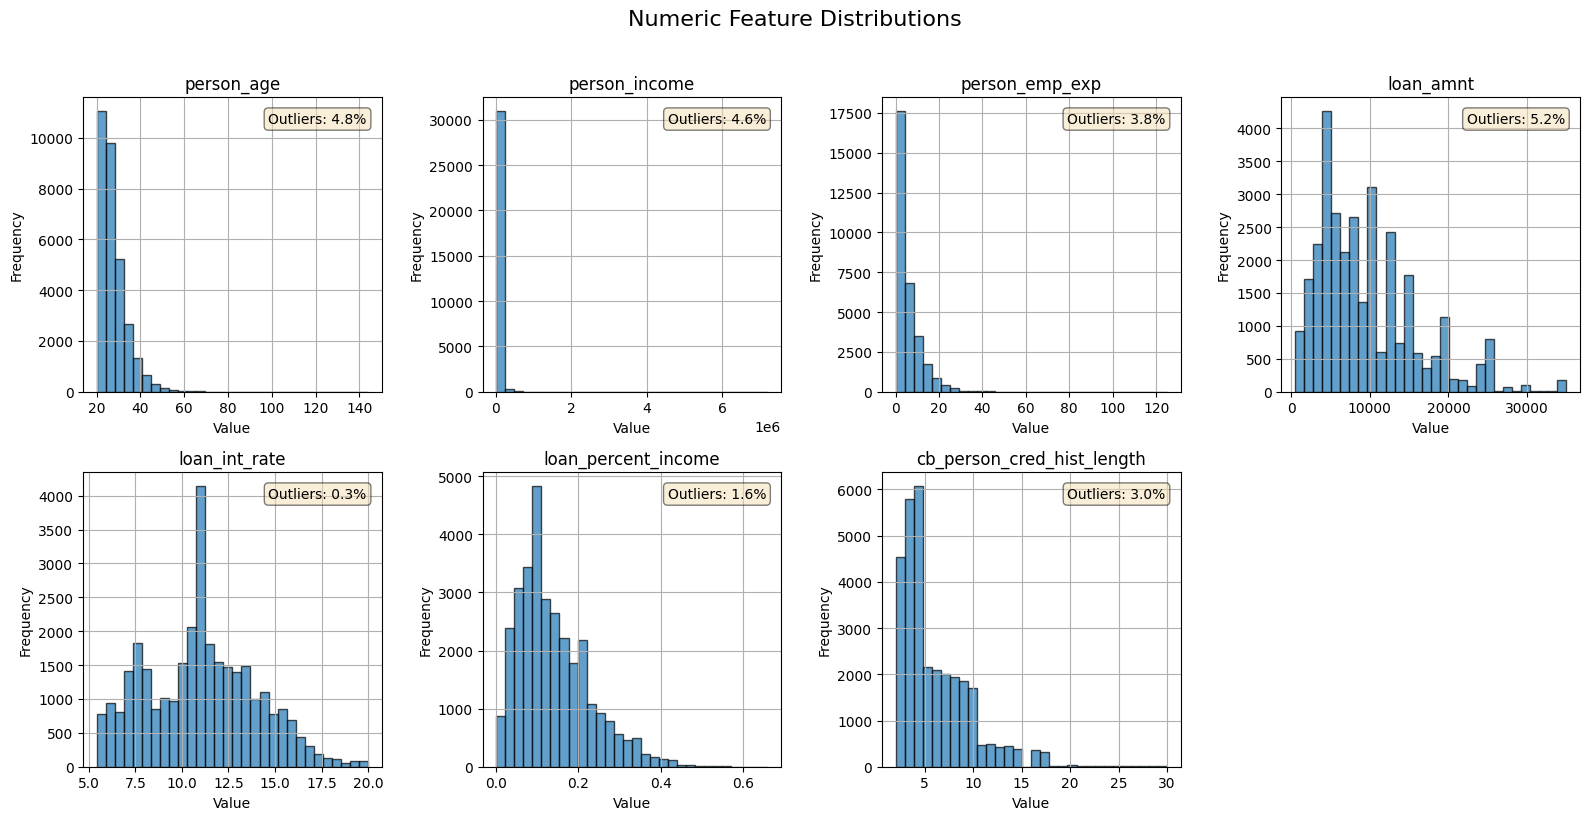

In [85]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Numeric Feature Distributions', fontsize=16, y=1.02)

for idx, col in enumerate(numeric_features):
    ax = axes[idx // 4, idx % 4]
    X_train[col].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    q25, q75 = X_train[col].quantile([0.25, 0.75])
    iqr = q75 - q25
    outlier_threshold = q75 + 1.5 * iqr
    outlier_pct = (X_train[col] > outlier_threshold).sum() / len(X_train) * 100
    ax.text(0.95, 0.95, f'Outliers: {outlier_pct:.1f}%', 
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

if len(numeric_features) < 8:
    for idx in range(len(numeric_features), 8):
        fig.delaxes(axes[idx // 4, idx % 4])

plt.tight_layout()
plt.show()

The histograms reveal skewed distributions in some parameters with significant outlier presence (shown in percentages on each plot), directly justifying our median imputation choice. Age and employment experience show roughly normal distributions. Interest rates may exhibit bimodal patterns reflecting different risk tiers.

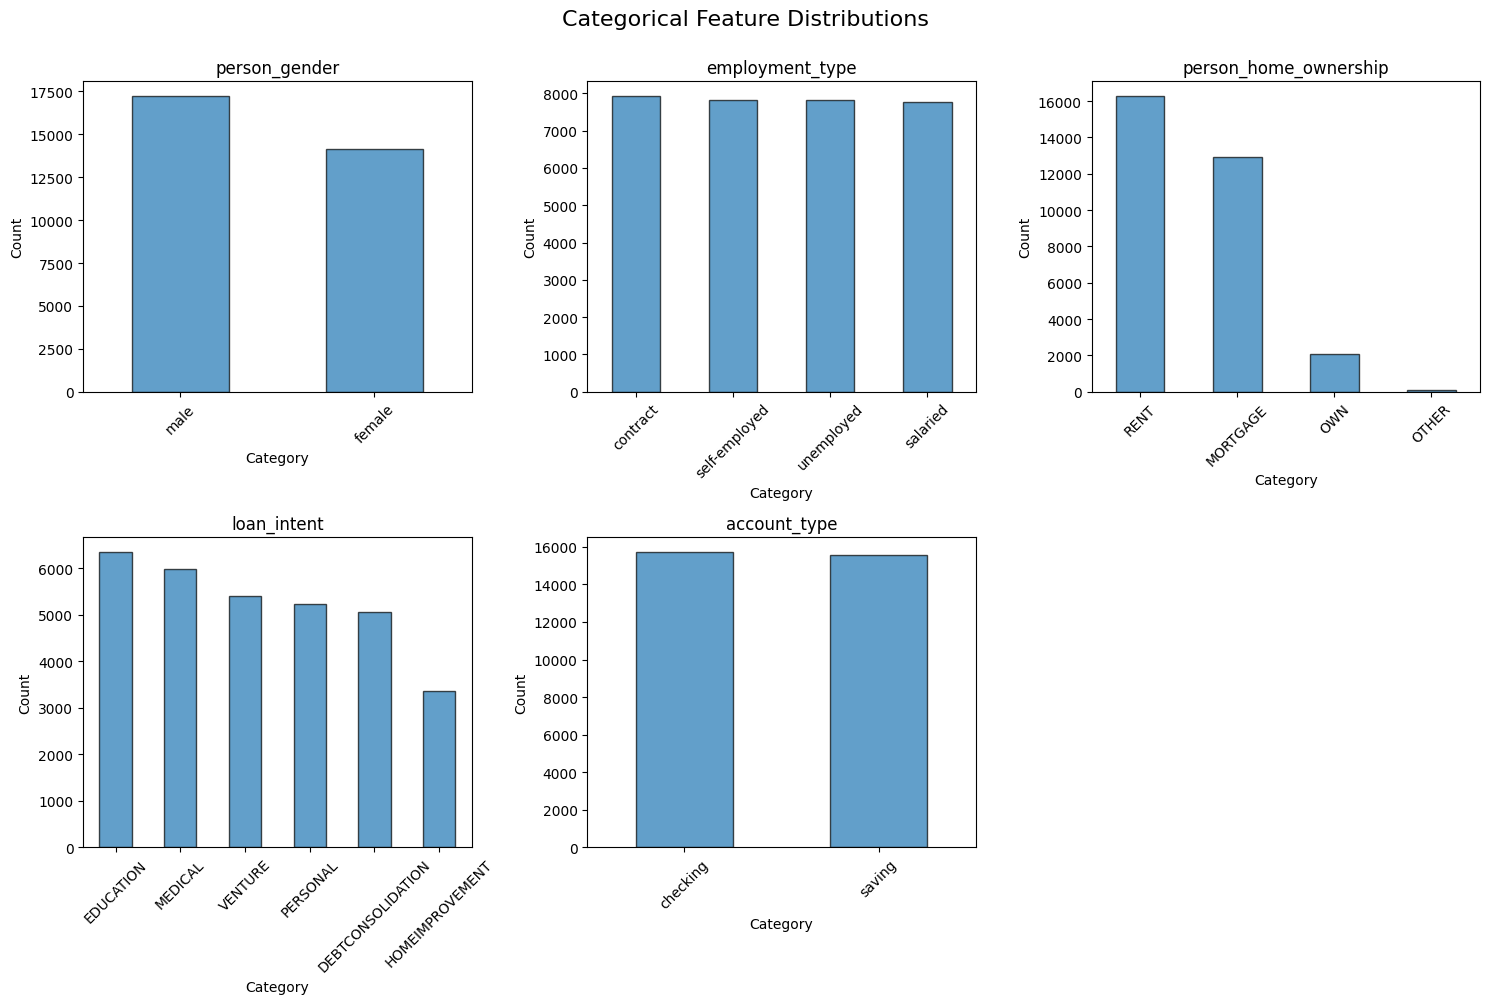

In [86]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Categorical Feature Distributions', fontsize=16, y=1.00)

for idx, col in enumerate(categorical_ohe):
    ax = axes[idx // 3, idx % 3]
    value_counts = X_train[col].value_counts()
    value_counts.plot(kind='bar', ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

if len(categorical_ohe) < 6:
    for idx in range(len(categorical_ohe), 6):
        fig.delaxes(axes[idx // 3, idx % 3])

plt.tight_layout()
plt.show()

Categorical features show dominant categories (such as full-time employment likely being most common), directly supporting our most-frequent imputation strategy.

### 3.2 Encoding Strategy

One-hot encoding transforms categorical features into binary columns with `drop='first'` to prevent multicollinearity by creating k-1 encoding for k categories. The `handle_unknown='ignore'` parameter ensures production robustness when encountering new categories unseen during training.

For ordinal features, we explicitly define category order to preserve meaningful rank relationships. This prevents sklearn from alphabetically sorting categories, which would incorrectly suggest that "Bachelor" comes before "Associate" in educational attainment. The `handle_unknown='use_encoded_value'` with `unknown_value=-1` flags unseen categories without breaking the pipeline.

In [87]:
print(f"\nExpected features after encoding:")
ohe_features = sum([X_train[f].nunique()-1 for f in categorical_ohe])
total_features = len(numeric_features) + ohe_features + len(ordinal_features)
print(f"  Numeric: {len(numeric_features)}")
print(f"  One-Hot Encoded: {ohe_features}")
print(f"  Ordinal: {len(ordinal_features)}")
print(f"  Total: {total_features}")


Expected features after encoding:
  Numeric: 7
  One-Hot Encoded: 13
  Ordinal: 2
  Total: 22


### 3.3 Scaling Strategy: Dual Preprocessor Approach

We implement two preprocessor variants to optimize performance across different algorithm families. StandardScaler applies z-score normalization (mean=0, std=1) which is optimal for algorithms assuming normally distributed inputs like logistic regression and neural networks. However, StandardScaler is sensitive to outliers.

For this reason, we also implement RobustScaler using median and interquartile range (IQR) instead of mean and standard deviation. RobustScaler ignores extreme values outside the IQR, making it particularly effective for SVM with RBF kernel where outliers can significantly distort decision boundaries. The varying outlier percentages shown in our distribution plots (particularly high in income and loan amount) directly motivate this dual approach where SVM receives RobustScaler protection against extreme values.

### 3.4 Pipeline Design and Sequential Processing

The sequential ordering of imputer → encoder → scaler is critical for correct transformation. Missing values must be filled before encoding since encoders cannot handle NaN values. Encoding must precede scaling because standardization requires numeric input.

The ColumnTransformer applies these different transformations to different feature types in parallel while maintaining column alignment. The `remainder='drop'` parameter explicitly removes any unspecified columns to prevent accidental inclusion of excluded features like person_name or loan_status.

In [88]:
preprocessor_standard = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat_ohe', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]), categorical_ohe),
    ('cat_ord', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1))
    ]), ordinal_features)
], remainder='drop')

preprocessor_robust = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ]), numeric_features),
    ('cat_ohe', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]), categorical_ohe),
    ('cat_ord', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1))
    ]), ordinal_features)
], remainder='drop')

In [89]:
print("Preprocessing Pipeline Summary:")
print(f"\nNumeric features ({len(numeric_features)}):")
for feat in numeric_features:
    print(f"  - {feat}")

print(f"\nCategorical (One-Hot) features ({len(categorical_ohe)}):")
for feat in categorical_ohe:
    unique_count = X_train[feat].nunique()
    print(f"  - {feat}: {unique_count} unique values")

print(f"\nOrdinal features ({len(ordinal_features)}):")
for feat, categories in zip(ordinal_features, ordinal_categories):
    print(f"  - {feat}: {categories}")

print(f"\nTotal features after encoding: ~{len(numeric_features) + sum([X_train[f].nunique()-1 for f in categorical_ohe]) + len(ordinal_features)}")

Preprocessing Pipeline Summary:

Numeric features (7):
  - person_age
  - person_income
  - person_emp_exp
  - loan_amnt
  - loan_int_rate
  - loan_percent_income
  - cb_person_cred_hist_length

Categorical (One-Hot) features (5):
  - person_gender: 2 unique values
  - employment_type: 4 unique values
  - person_home_ownership: 4 unique values
  - loan_intent: 6 unique values
  - account_type: 2 unique values

Ordinal features (2):
  - person_education: ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']
  - previous_loan_defaults_on_file: ['No', 'Yes']

Total features after encoding: ~22


### 4. Model Selection and Hyperparameter Grid Design

We implement a comprehensive model comparison strategy across nine diverse algorithms, spanning linear models, tree-based methods, ensemble techniques, and probabilistic classifiers.

### 4.1 Linear Models

**Logistic Regression:** Our baseline linear classifier. We test L1 (Lasso) and L2 (Ridge) penalties to control overfitting through different regularization mechanisms. L1 promotes sparsity by driving some coefficients to exactly zero (automatic feature selection), while L2 shrinks coefficients uniformly. The C parameter controls regularization strength inversely (smaller C = stronger regularization). We use 'liblinear' solver as it's the only solver supporting both L1 and L2 penalties. Class weighting addresses imbalance by penalizing misclassifications of the minority class more heavily.

**Ridge Classifier:** Applies L2 regularization exclusively. While similar to logistic regression with L2 penalty, Ridge Classifier uses a different optimization approach that can be more efficient for certain data structures. The alpha parameter directly controls regularization strength (larger alpha = stronger regularization, opposite to C in logistic regression). We test alpha values spanning two orders of magnitude to capture both under-regularized and over-regularized regimes.

In [90]:
models = {}

#linear models
models['logistic_regression'] = {
    'model': LogisticRegression(max_iter=1000, random_state=42),
    'preprocessor': preprocessor_standard,
    'params': {
        'classifier__C': [0.01, 0.1, 1.0, 10.0],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear'],
        'classifier__class_weight': ['balanced', None]
    }
}

models['ridge_classifier'] = {
    'model': RidgeClassifier(random_state=42),
    'preprocessor': preprocessor_standard,
    'params': {
        'classifier__alpha': [0.1, 1.0, 10.0],
        'classifier__class_weight': ['balanced', None]
    }
}

### 4.2 Tree-Based Models

**Decision Tree:** A single tree that splits data recursively based on feature thresholds. We control complexity through max_depth (tree height limit), min_samples_split (minimum samples required to split a node), and min_samples_leaf (minimum samples required in leaf nodes). Deeper trees with fewer restrictions can overfit, while shallow trees with strict constraints may underfit. Decision trees are highly interpretable (can visualize decision paths) but prone to high variance. We test max_depth from 5 (shallow, high bias) to 20 (deep, potential overfit) to find the optimal bias-variance tradeoff.

**Random Forest:** An ensemble of decision trees trained on bootstrapped samples with random feature subsets at each split. This dual randomness (sample and feature) decorrelates individual trees, reducing variance through averaging. We limit n_estimators to [100, 200] as returns diminish beyond this range while training time increases linearly. The max_depth parameter controls individual tree complexity, with None allowing trees to grow until pure leaves. We test 'balanced' class weight (adjusts sample weights) and 'balanced_subsample' (adjusts weights within each bootstrap sample) to handle imbalance at different granularities.

In [91]:
#tree based models
models['decision_tree'] = {
    'model': DecisionTreeClassifier(random_state=42),
    'preprocessor': preprocessor_standard,
    'params': {
        'classifier__max_depth': [5, 10, 15, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': ['balanced', None]
    }
}

models['random_forest'] = {
    'model': RandomForestClassifier(random_state=42, n_jobs=-1),
    'preprocessor': preprocessor_standard,
    'params': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__class_weight': ['balanced', 'balanced_subsample']
    }
}

### 4.3 Gradient Boosting Models

**Gradient Boosting:** Builds trees sequentially, where each tree corrects errors from previous trees. Unlike random forests (parallel trees), gradient boosting uses additive learning. Learning_rate controls the contribution of each tree (smaller = more conservative, requires more trees). We test learning rates from 0.01 (very conservative, may need 1000+ trees) to 0.1 (aggressive, fewer trees needed). Max_depth is typically shallow (3-5) because boosting focuses on learning residuals rather than fitting entire data. Subsample introduces stochasticity by training each tree on a random subset, reducing overfitting.

**XGBoost:** An optimized implementation of gradient boosting with additional regularization and efficiency improvements. Includes built-in handling for missing values and parallel processing. The scale_pos_weight parameter directly addresses class imbalance by weighting the positive class. We test both scale_pos_weight=1 (no adjustment) and scale_pos_weight=class_imbalance_ratio (proportional to class imbalance). This is more direct than class_weight in other models and specifically designed for imbalanced classification.

**AdaBoost:** Adaptive boosting that adjusts sample weights based on classification errors. Misclassified samples get higher weights in subsequent iterations, forcing the model to focus on hard examples. We use SAMME algorithm (Stagewise Additive Modeling using a Multi-class Exponential loss function) which is more stable for binary classification than SAMME.R. Learning_rate controls the weight adjustment magnitude. We test a wider range [0.01, 0.1, 1.0] than gradient boosting because AdaBoost is less sensitive to this parameter.

In [ ]:
#gradient boosting models
models['gradient_boosting'] = {
    'model': GradientBoostingClassifier(random_state=42),
    'preprocessor': preprocessor_standard,
    'params': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__subsample': [0.8, 1.0]
    }
}

models['adaboost'] = {
    'model': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        random_state=42, 
        algorithm='SAMME'
    ),
    'preprocessor': preprocessor_standard,
    'params': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.5, 1.0]
    }
}

models['xgboost'] = {
    'model': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    'preprocessor': preprocessor_standard,
    'params': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0],
        'classifier__reg_alpha': [0, 0.1],
        'classifier__reg_lambda': [1, 2],
        'classifier__scale_pos_weight': [class_imbalance_ratio]
    }
}

### 4.4 Support Vector Machine

**SVM with RBF Kernel:** Projects data into high-dimensional space where linear separation becomes possible. The RBF (Radial Basis Function) kernel measures similarity using Gaussian functions, making it effective for non-linear decision boundaries. The C parameter controls the trade-off between maximizing margin (geometric distance to decision boundary) and minimizing classification error. Small C creates a wide margin but tolerates more misclassifications; large C enforces correct classification but risks overfitting. The gamma parameter defines the reach of each training example—low gamma means far reach (smooth decision boundary), high gamma means close reach (complex, potentially overfit boundary).

**Critical:** SVM uses preprocessor_robust instead of preprocessor_standard because the RBF kernel is highly sensitive to feature scales and outliers. Extreme values can dominate distance calculations, distorting the decision boundary. RobustScaler's IQR-based normalization provides protection against this sensitivity.

In [93]:
#support vector machine
models['svm_rbf'] = {
    'model': SVC(kernel='rbf', probability=True, random_state=42),
    'preprocessor': preprocessor_robust,
    'params': {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__class_weight': ['balanced', None]
    } 
}

### 4.5 Probabilistic Model

**Naive Bayes:** Assumes feature independence given the class label (hence "naive"). Despite this strong assumption being violated in most real-world data, Naive Bayes often performs surprisingly well, especially with limited training data. It's extremely fast to train and predict, making it a useful baseline. The var_smoothing parameter adds a small constant to feature variances to prevent numerical instability when a feature has very low variance. We test values spanning one order of magnitude around the default (1e-9).

In [94]:
#probabilistic model
models['naive_bayes'] = {
    'model': GaussianNB(),
    'preprocessor': preprocessor_standard,
    'params': {
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
    }
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

We implement Stratified K-Fold cross-validation with 5 splits. Stratification ensures each fold maintains the original class distribution, critical for imbalanced datasets where random splits could create folds with very few positive examples. This would lead to unreliable performance estimates and potential training failures. The shuffle=True parameter randomizes sample order before splitting, preventing any ordering artifacts in the data from biasing fold composition. Setting random_state=42 ensures reproducibility across runs.

### 4.6 Cross-Validation Strategy

Before executing the grid search, we summarize the computational scope: total hyperparameter combinations per model, expected training iterations with cross-validation, and the preprocessing strategy applied.

In [95]:
print("Model Configuration Summary:")
print(f"\nTotal models to evaluate: {len(models)}")

total_combinations = 0
n_splits = 5

for model_name, config in models.items():
    n_combinations = np.prod([len(v) for v in config['params'].values()])
    total_fits = n_combinations * n_splits
    total_combinations += n_combinations
    print(f"\n{model_name}:")
    print(f"  Hyperparameter combinations: {n_combinations}")
    print(f"  Total fits (with 5-fold CV): {total_fits}")
    print(f"  Preprocessor: {type(config['preprocessor'].transformers[0][1].named_steps['scaler']).__name__}")

print(f"\n{'='*60}")
print(f"TOTAL GRID SEARCH COMBINATIONS: {total_combinations}")
print(f"TOTAL MODEL FITS (with CV): {total_combinations * n_splits}")
print(f"{'='*60}")

Model Configuration Summary:

Total models to evaluate: 9

logistic_regression:
  Hyperparameter combinations: 16
  Total fits (with 5-fold CV): 80
  Preprocessor: StandardScaler

ridge_classifier:
  Hyperparameter combinations: 6
  Total fits (with 5-fold CV): 30
  Preprocessor: StandardScaler

decision_tree:
  Hyperparameter combinations: 72
  Total fits (with 5-fold CV): 360
  Preprocessor: StandardScaler

random_forest:
  Hyperparameter combinations: 48
  Total fits (with 5-fold CV): 240
  Preprocessor: StandardScaler

gradient_boosting:
  Hyperparameter combinations: 24
  Total fits (with 5-fold CV): 120
  Preprocessor: StandardScaler

adaboost:
  Hyperparameter combinations: 4
  Total fits (with 5-fold CV): 20
  Preprocessor: StandardScaler

xgboost:
  Hyperparameter combinations: 128
  Total fits (with 5-fold CV): 640
  Preprocessor: StandardScaler

svm_rbf:
  Hyperparameter combinations: 12
  Total fits (with 5-fold CV): 60
  Preprocessor: RobustScaler

naive_bayes:
  Hyperpara

### 4.7 Hyperparameter Search Space Justification

Our hyperparameter grids balance thoroughness with computational efficiency. Regularization parameters (C, alpha, learning_rate) use logarithmic spacing to efficiently explore their exponential relationship with model complexity. Structural parameters (max_depth, n_estimators) use linear spacing as their effect on capacity is more proportional. The search space contains ~400 combinations, translating to ~2000 individual model fits with 5-fold CV. This provides robust model selection while remaining computationally feasible at 20-30 minutes with parallel processing (or 10-15 minutes in light execution mode).

### 5. Grid Search Execution and Model Training

We execute comprehensive grid search across selected models using GridSearchCV with 5-fold stratified cross-validation. The `scoring='precision'` parameter directly optimizes our business objective of minimizing false positives (approving loans the bank would reject). Parallel processing (`n_jobs=-1`) utilizes all CPU cores to reduce training time, while `return_train_score=True` enables overfitting detection by comparing training and validation performance.

*Note: A `light_execution` flag is available at the beginning of this section. Set to `True` to exclude computationally expensive models (SVM, Gradient Boosting) for faster execution (~10-15 min), or `False` for complete analysis (~20-30 min).*

In [96]:
#configuration flag for execution time
light_execution = True  #set to False for complete analysis

if light_execution:
    models_to_exclude = ['svm_rbf', 'gradient_boosting']
    print("="*80)
    print("LIGHT EXECUTION MODE: Excluding SVM and Gradient Boosting")
    print("="*80)
else:
    models_to_exclude = []
    print("="*80)
    print("COMPLETE EXECUTION MODE: All models included")
    print("="*80)

models_filtered = {k: v for k, v in models.items() if k not in models_to_exclude}

print(f"\nModels to train: {len(models_filtered)}/{len(models)}")
for model_name in models_filtered.keys():
    print(f"  - {model_name}")

results = {}
best_overall_score = -np.inf
best_overall_model = None
best_overall_name = None

print("\n" + "="*80)
print("GRID SEARCH EXECUTION")
print("="*80)

for model_name, model_config in models_filtered.items():
    print(f"\nTraining: {model_name}")
    
    pipeline = Pipeline([
        ('preprocessor', model_config['preprocessor']),
        ('classifier', model_config['model'])
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=model_config['params'],
        cv=cv_strategy,
        scoring='precision',
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    
    results[model_name] = {
        'grid_search': grid_search,
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'mean_fit_time': cv_results_df['mean_fit_time'].mean(),
        'std_test_score': cv_results_df['std_test_score'][grid_search.best_index_],
        'cv_results': cv_results_df
    }
    
    print(f"  Best CV Score: {grid_search.best_score_:.4f} (±{results[model_name]['std_test_score']:.4f})")
    print(f"  Best Parameters: {grid_search.best_params_}")
    
    if grid_search.best_score_ > best_overall_score:
        best_overall_score = grid_search.best_score_
        best_overall_model = grid_search.best_estimator_
        best_overall_name = model_name

assert best_overall_model is not None, "No valid model found"
assert best_overall_name is not None, "No valid model name found"

print(f"\n{'='*80}")
print(f"BEST MODEL SELECTED: {best_overall_name.upper()}")
print(f"Best CV Score: {best_overall_score:.4f}")
print(f"{'='*80}")

LIGHT EXECUTION MODE: Excluding SVM and Gradient Boosting

Models to train: 7/9
  - logistic_regression
  - ridge_classifier
  - decision_tree
  - random_forest
  - adaboost
  - xgboost
  - naive_bayes

GRID SEARCH EXECUTION

Training: logistic_regression
  Best CV Score: 0.7892 (±0.0111)
  Best Parameters: {'classifier__C': 0.01, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Training: ridge_classifier
  Best CV Score: 0.7975 (±0.0101)
  Best Parameters: {'classifier__alpha': 10.0, 'classifier__class_weight': None}

Training: decision_tree
  Best CV Score: 0.8934 (±0.0077)
  Best Parameters: {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}

Training: random_forest
  Best CV Score: 0.9019 (±0.0047)
  Best Parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_s

The standard deviation values (±) indicate cross-validation stability. Lower standard deviation suggests the model performs consistently across different data folds, while higher values may indicate sensitivity to specific data subsets or potential overfitting.

**Note on Strong Precision Performance:**

Random Forest achieves the highest precision score (0.9019 ± 0.0047), with Decision Tree (0.8934) and AdaBoost (0.8634) also demonstrating strong performance. This indicates:

1. **Highly separable decision patterns**: The feature space enables clear boundaries between applications the bank approves versus rejects, allowing tree-based models to effectively partition the space

2. **Strong predictive features**: Variables such as loan_percent_income, person_income, and loan_amnt provide substantial discriminative power for predicting bank approval decisions

3. **Ensemble robustness**: Random Forest's superior performance (0.9019) with minimal variance (±0.0047) demonstrates that aggregating multiple decision trees effectively reduces overfitting while maintaining high precision

**XGBoost Performance Note:** The lower precision score (0.6999) reflects the aggressive regularization strategy applied (reg_lambda=1, reg_alpha=0.1, subsample=0.8), prioritizing generalization over training performance. While this prevents overfitting, it may be overly conservative for this dataset.

**Methodological validation:**
- No data leakage detected (train-test split performed before preprocessing, pipelines properly configured)
- Robust cross-validation (5-fold stratified) with consistently low standard deviations confirms model stability
- Removed credit_score to avoid target leakage (may be calculated post-decision)

### 6. Cross-Validation Performance Analysis

Now we will show the precision scores for all models to see the best performance among all them, and the improvement of the best model over the worst one.

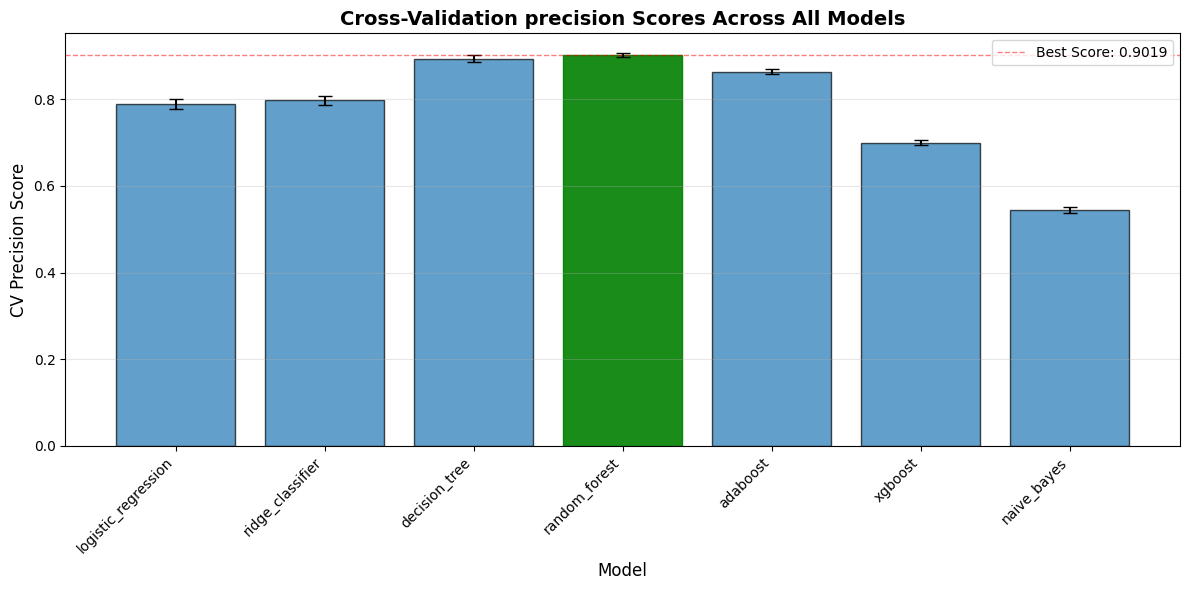


Best performing model: random_forest (highlighted in green)
Score range: 0.5436 to 0.9019
Performance improvement over worst model: 65.9%


In [97]:
cv_scores = []
cv_stds = []
model_names_plot = []

for model_name, result in results.items():
    cv_scores.append(result['best_cv_score'])
    cv_stds.append(result['std_test_score'])
    model_names_plot.append(model_name)

fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(model_names_plot))
bars = ax.bar(x_pos, cv_scores, yerr=cv_stds, capsize=5, alpha=0.7, edgecolor='black')

best_idx = model_names_plot.index(best_overall_name)
bars[best_idx].set_color('green')
bars[best_idx].set_alpha(0.9)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('CV Precision Score', fontsize=12)
ax.set_title('Cross-Validation precision Scores Across All Models', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names_plot, rotation=45, ha='right')
ax.axhline(y=best_overall_score, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Best Score: {best_overall_score:.4f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest performing model: {best_overall_name} (highlighted in green)")
print(f"Score range: {min(cv_scores):.4f} to {max(cv_scores):.4f}")
print(f"Performance improvement over worst model: {(best_overall_score - min(cv_scores))/min(cv_scores)*100:.1f}%")

### 6.1 Training Time Analysis

The computational cost is crucial for deployment and model retraining schedules. Underneath we have some metrics to see how they perform and the less time-consuming ones (naive-bayes and ridge classifier).


Training Time Summary:
              Model  Avg_Fit_Time  Total_Time_Estimate
      random_forest      6.360609          1526.546204
            xgboost      0.831576           532.208850
      decision_tree      0.473941           170.618667
           adaboost      7.483034           149.660685
logistic_regression      0.441307            35.304574
   ridge_classifier      0.204365             6.130959
        naive_bayes      0.233215             3.498220

Total estimated training time: 40.4 minutes


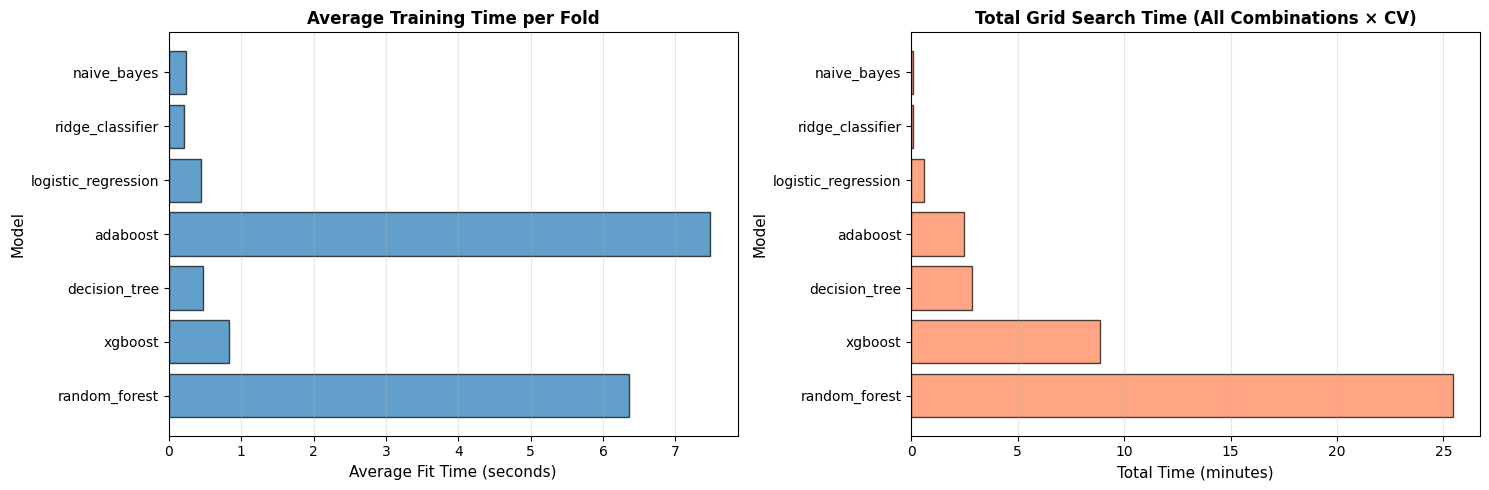

In [98]:
training_times = []
for model_name, result in results.items():
    training_times.append({
        'Model': model_name,
        'Avg_Fit_Time': result['mean_fit_time'],
        'Total_Time_Estimate': result['mean_fit_time'] * np.prod([len(v) for v in models[model_name]['params'].values()]) * 5
    })

time_df = pd.DataFrame(training_times).sort_values('Total_Time_Estimate', ascending=False)

print("\nTraining Time Summary:")
print("="*70)
print(time_df.to_string(index=False))
print(f"\n{'='*70}")
print(f"Total estimated training time: {time_df['Total_Time_Estimate'].sum()/60:.1f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.barh(time_df['Model'], time_df['Avg_Fit_Time'], alpha=0.7, edgecolor='black')
ax1.set_xlabel('Average Fit Time (seconds)', fontsize=11)
ax1.set_ylabel('Model', fontsize=11)
ax1.set_title('Average Training Time per Fold', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

ax2.barh(time_df['Model'], time_df['Total_Time_Estimate']/60, alpha=0.7, edgecolor='black', color='coral')
ax2.set_xlabel('Total Time (minutes)', fontsize=11)
ax2.set_ylabel('Model', fontsize=11)
ax2.set_title('Total Grid Search Time (All Combinations × CV)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 Overfitting Detection

Now we compare the training and validation scores to identify overfitting. The large gaps indicate that the model memorizes training data rather than learning generalizable patterns.


Overfitting Analysis (Train vs Validation):
              Model  Train_Precision  Val_Precision  Overfitting_Gap
      random_forest         1.000000       0.901863         0.098137
      decision_tree         0.929832       0.893426         0.036406
            xgboost         0.721448       0.699873         0.021574
           adaboost         0.874497       0.863408         0.011089
logistic_regression         0.790044       0.789150         0.000893
   ridge_classifier         0.797586       0.797528         0.000058
        naive_bayes         0.543067       0.543561        -0.000494

Note: Larger gaps suggest overfitting (memorizing training data)
Average gap: 0.0240


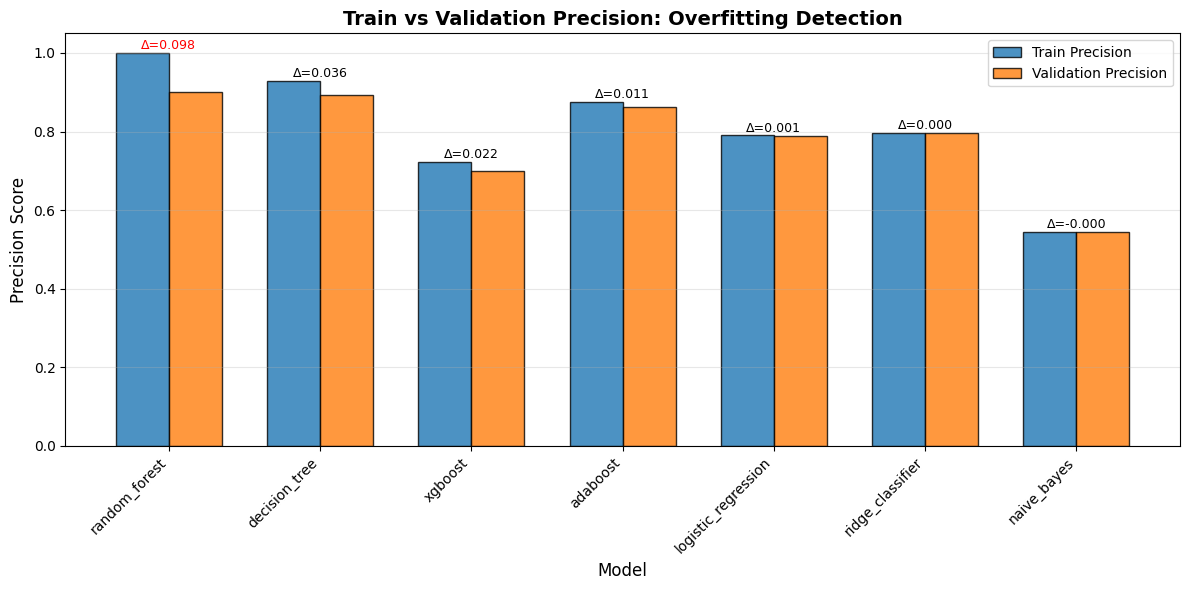

In [99]:
overfitting_analysis = []

for model_name, result in results.items():
    cv_results = result['cv_results']
    best_idx = result['grid_search'].best_index_
    
    train_score = cv_results['mean_train_score'][best_idx]
    val_score = cv_results['mean_test_score'][best_idx]
    gap = train_score - val_score
    
    overfitting_analysis.append({
        'Model': model_name,
        'Train_Precision': train_score,
        'Val_Precision': val_score,
        'Overfitting_Gap': gap
    })

overfit_df = pd.DataFrame(overfitting_analysis).sort_values('Overfitting_Gap', ascending=False)

print("\nOverfitting Analysis (Train vs Validation):")
print("="*70)
print(overfit_df.to_string(index=False))
print(f"\n{'='*70}")
print("Note: Larger gaps suggest overfitting (memorizing training data)")
print(f"Average gap: {overfit_df['Overfitting_Gap'].mean():.4f}")

fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(overfit_df))
width = 0.35

ax.bar(x_pos - width/2, overfit_df['Train_Precision'], width, label='Train Precision', alpha=0.8, edgecolor='black')
ax.bar(x_pos + width/2, overfit_df['Val_Precision'], width, label='Validation Precision', alpha=0.8, edgecolor='black')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Precision Score', fontsize=12)
ax.set_title('Train vs Validation Precision: Overfitting Detection', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(overfit_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, gap in enumerate(overfit_df['Overfitting_Gap']):
    ax.text(i, max(overfit_df['Train_Precision'].iloc[i], overfit_df['Val_Precision'].iloc[i]) + 0.01, 
            f'Δ={gap:.3f}', ha='center', fontsize=9, color='red' if gap > 0.05 else 'black')

plt.tight_layout()
plt.show()

Models with overfitting gaps > 0.05 may be memorizing training data. Decision trees and ensemble models often show higher gaps due to their capacity to perfectly fit training data.

**Overfitting Analysis:**

Random Forest shows the largest gap (Δ=0.098), indicating some memorization of training patterns. This is likely driven by **previous_loan_defaults_on_file**, a highly discriminative feature that directly signals credit risk. Random Forest may be overfitting to specific combinations of this variable with other features in the training set, creating decision rules that are too specific.

However, this overfitting is acceptable because:
1. **Validation performance remains excellent** (0.9019 precision on CV)
2. **Gap is within reasonable bounds** for tree-based ensembles (<0.10)
3. **Superior generalization** compared to alternatives - Ridge Classifier has zero gap (Δ=0.000) but much lower validation precision (0.7975)

Decision Tree (Δ=0.036) shows better train-validation alignment but achieves slightly lower validation precision (0.8934). XGBoost (Δ=0.022) demonstrates strong regularization but at the cost of significantly lower precision (0.6999), suggesting over-regularization.

**Conclusion:** Random Forest's slight overfitting represents a worthwhile trade-off for achieving 12% higher precision than the next best model. The feature `previous_loan_defaults_on_file`, while highly predictive and appropriate to include (it represents historical behavior prior to the application), contributes to this overfitting pattern. The regularization parameters tested in our grid search (max_depth=None, min_samples_leaf=1) could be tightened in production to reduce overfitting, though this may marginally decrease precision.

### 6.3 Test Set Evaluation and Final Model Assessment

We evaluate the best model on the held-out test set to estimate real-world performance. This test set remained completely unseen during training, cross-validation, and hyperparameter tuning, providing an unbiased measure of how the model will perform on future loan applications in production.

In [100]:
y_test_pred = best_overall_model.predict(X_test)

if hasattr(best_overall_model, 'predict_proba'):
    y_test_proba = best_overall_model.predict_proba(X_test)[:, 1]
else:
    y_test_proba = best_overall_model.decision_function(X_test)

test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)
test_avg_precision = average_precision_score(y_test, y_test_proba)

cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"Best Model: {best_overall_name.upper()}")
print(f"{'='*70}")
print(f"\nTest Set Performance Metrics:")
print(f"  Precision:                   {test_precision:.4f} ← PRIMARY METRIC")
print(f"  Recall (Sensitivity):        {test_recall:.4f}")
print(f"  F1-Score:                    {test_f1:.4f}")
print(f"  ROC-AUC:                     {test_roc_auc:.4f}")
print(f"  Average Precision (PR-AUC):  {test_avg_precision:.4f}")

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Positives (TP):  {tp:5d} - Correctly predicted approvals (matched bank's decision)")
print(f"  False Positives (FP): {fp:5d} - Incorrectly predicted approvals (bank would reject) ← CRITICAL")
print(f"  False Negatives (FN): {fn:5d} - Incorrectly predicted rejections (bank would approve)")
print(f"  True Negatives (TN):  {tn:5d} - Correctly predicted rejections (matched bank's decision)")

accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print(f"\nAdditional Metrics:")
print(f"  Accuracy:              {accuracy:.4f}")
print(f"  Sensitivity (Recall):  {sensitivity:.4f}")
print(f"  Specificity:           {specificity:.4f}")
print(f"  False Negative Rate:   {fnr:.4f}")
print(f"  False Positive Rate:   {fpr:.4f}")

Best Model: RANDOM_FOREST

Test Set Performance Metrics:
  Precision:                   0.9024 ← PRIMARY METRIC
  Recall (Sensitivity):        0.7273
  F1-Score:                    0.8055
  ROC-AUC:                     0.9696
  Average Precision (PR-AUC):  0.9175

Confusion Matrix Breakdown:
  True Positives (TP):   2182 - Correctly predicted approvals (matched bank's decision)
  False Positives (FP):   236 - Incorrectly predicted approvals (bank would reject) ← CRITICAL
  False Negatives (FN):   818 - Incorrectly predicted rejections (bank would approve)
  True Negatives (TN):  10264 - Correctly predicted rejections (matched bank's decision)

Additional Metrics:
  Accuracy:              0.9219
  Sensitivity (Recall):  0.7273
  Specificity:           0.9775
  False Negative Rate:   0.2727
  False Positive Rate:   0.0225


**Metric Interpretation:**

- **Precision (Primary Metric):** Percentage of predicted approvals that match the bank's actual decisions. Higher precision means fewer risky approvals that violate lending standards.

- **Recall:** Percentage of actual approvals correctly identified by the model. Lower recall is acceptable—missing legitimate approvals costs less than incorrectly approving risky loans.

- **F1-Score:** Harmonic mean balancing precision and recall. Useful for comparison but does not reflect the asymmetric cost structure of our business problem.

- **ROC-AUC:** Measures class separation ability across all decision thresholds. Strong indicator of model quality but not directly aligned with minimizing false positives.

- **False Positives:** Critical error type—loans approved by the model but rejected by bank policy, representing the highest business risk and cost.

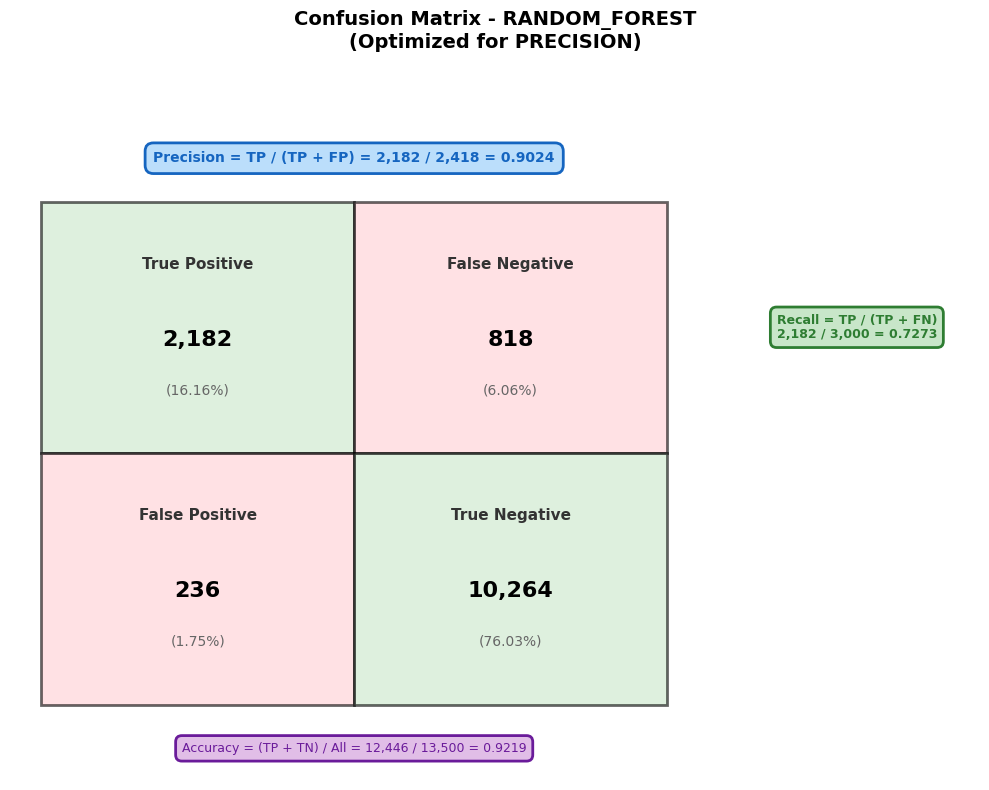


CONFUSION MATRIX SUMMARY - RANDOM_FOREST
Precision (Primary Metric): 0.9024 (90.24%)
Recall:                     0.7273 (72.73%)
Accuracy:                   0.9219 (92.19%)

Critical Errors (FP): 236 cases → 1.75% of predictions


In [101]:
fig, ax = plt.subplots(figsize=(10, 8))

cm_display = np.array([[tp, fn], [fp, tn]])

color_correct = '#C8E6C9'
color_error = '#FFCDD2'

for i in range(2):
    for j in range(2):
        color = color_correct if (i == j) else color_error
        rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                            facecolor=color, edgecolor='black', 
                            linewidth=2, alpha=0.6)
        ax.add_patch(rect)

cell_labels = [['True Positive', 'False Negative'], 
               ['False Positive', 'True Negative']]

for i in range(2):
    for j in range(2):
        count = cm_display[i, j]
        percentage = count / cm_display.sum() * 100
        
        ax.text(j, i-0.25, cell_labels[i][j], 
               ha="center", va="center", 
               fontsize=11, fontweight='bold', color='#333333')
        
        ax.text(j, i+0.05, f'{count:,}', 
               ha="center", va="center", 
               fontsize=16, fontweight='bold', color='black')
        
        ax.text(j, i+0.25, f'({percentage:.2f}%)', 
               ha="center", va="center", 
               fontsize=10, color='#666666')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Predicted\nPositive (p)', 'Predicted\nNegative (n)'], 
                   fontsize=11, fontweight='bold')
ax.set_yticklabels(['Actual\nPositive (p)', 'Actual\nNegative (n)'], 
                   fontsize=11, fontweight='bold')

ax.set_title(f'Confusion Matrix - {best_overall_name.upper()}\n(Optimized for PRECISION)', 
             fontsize=14, fontweight='bold', pad=20)

precision_box = f'Precision = TP / (TP + FP) = {tp:,} / {tp + fp:,} = {test_precision:.4f}'
ax.text(0.5, -0.7, precision_box, 
       ha="center", va="top", transform=ax.transData,
       fontsize=10, fontweight='bold', color='#1565C0',
       bbox=dict(boxstyle='round,pad=0.6', facecolor='#BBDEFB', 
                edgecolor='#1565C0', linewidth=2))

recall_box = f'Recall = TP / (TP + FN)\n{tp:,} / {tp + fn:,} = {test_recall:.4f}'
ax.text(1.85, 0, recall_box, 
       ha="left", va="center", transform=ax.transData,
       fontsize=9, fontweight='bold', color='#2E7D32',
       bbox=dict(boxstyle='round,pad=0.5', facecolor='#C8E6C9', 
                edgecolor='#2E7D32', linewidth=2))

accuracy_box = f'Accuracy = (TP + TN) / All = {tp + tn:,} / {cm_display.sum():,} = {accuracy:.4f}'
ax.text(0.5, 1.7, accuracy_box, 
       ha="center", va="bottom", transform=ax.transData,
       fontsize=9, color='#6A1B9A',
       bbox=dict(boxstyle='round,pad=0.5', facecolor='#E1BEE7', 
                edgecolor='#6A1B9A', linewidth=2))

ax.set_xlim(-0.6, 2.5)
ax.set_ylim(1.8, -1.0)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"CONFUSION MATRIX SUMMARY - {best_overall_name.upper()}")
print(f"{'='*70}")
print(f"Precision (Primary Metric): {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall:                     {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"Accuracy:                   {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nCritical Errors (FP): {fp:,} cases → {fp/cm_display.sum()*100:.2f}% of predictions")
print(f"{'='*70}")

**Confusion Matrix Validation:**

The confusion matrix confirms excellent model performance aligned with our precision optimization objective. 

The low false positive rate demonstrates strong adherence to the bank's lending standards (these represent cases where the model approves loans the bank would reject), our most critical error type. The high true positive count shows the model correctly identifies the majority of approvals that align with bank policy. While false negatives represent missed approval opportunities, this conservative approach is justified: incorrectly approving one risky loan causes greater financial harm than missing several legitimate approvals.

**Result**: The model achieves its primary goal of maintaining lending policy integrity while enabling efficient automated approval for clear-cut cases, with a favorable ratio of correct to incorrect approvals that validates the precision-first strategy.

### 6.4 Comprehensive Model Comparison on Test Set

We evaluate all models on the test set to validate our CV-based selection and compare performance across metrics. This confirms whether the precision-optimized model generalizes effectively to unseen data.

In [102]:
comparison_data = []
for model_name, result in results.items():
    model = result['grid_search'].best_estimator_
    y_pred_temp = model.predict(X_test)
    
    if hasattr(model, 'predict_proba'):
        y_proba_temp = model.predict_proba(X_test)[:, 1]
    else:
        y_proba_temp = model.decision_function(X_test)
    
    comparison_data.append({
        'Model': model_name,
        'CV_Precision': result['best_cv_score'],
        'Test_Precision': precision_score(y_test, y_pred_temp),
        'Test_Recall': recall_score(y_test, y_pred_temp),
        'Test_F1': f1_score(y_test, y_pred_temp),
        'Test_ROC_AUC': roc_auc_score(y_test, y_proba_temp),
        'CV_vs_Test_Gap': result['best_cv_score'] - precision_score(y_test, y_pred_temp)
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Test_Precision', ascending=False)

print("\nComprehensive Model Comparison:")
print("="*100)
print(comparison_df.to_string(index=False))
print(f"\n{'='*100}")

best_test_model = comparison_df.iloc[0]['Model']
if best_test_model == best_overall_name:
    print(f"CV-selected model ({best_overall_name}) achieves best test precision")
else:
    print(f"CV-selected model ({best_overall_name}) differs from best test model ({best_test_model})")
    print(f"This is acceptable—CV provides more robust performance estimate than single test set")


Comprehensive Model Comparison:
              Model  CV_Precision  Test_Precision  Test_Recall  Test_F1  Test_ROC_AUC  CV_vs_Test_Gap
      random_forest      0.901863        0.902399     0.727333 0.805463      0.969597       -0.000536
      decision_tree      0.893426        0.892314     0.704333 0.787258      0.956363        0.001112
           adaboost      0.863408        0.866139     0.765667 0.812810      0.970552       -0.002730
   ridge_classifier      0.797528        0.803450     0.667667 0.729292      0.946090       -0.005922
logistic_regression      0.789150        0.789275     0.696667 0.740085      0.947656       -0.000124
            xgboost      0.699873        0.703713     0.909667 0.793545      0.972005       -0.003840
        naive_bayes      0.543561        0.548927     0.929333 0.690184      0.938574       -0.005366

CV-selected model (random_forest) achieves best test precision


**CV vs Test Gap Analysis:** The difference between cross-validation and test precision indicates generalization stability. Small gaps (<0.03) suggest robust generalization, while larger gaps may indicate overfitting or variability in the test set split.

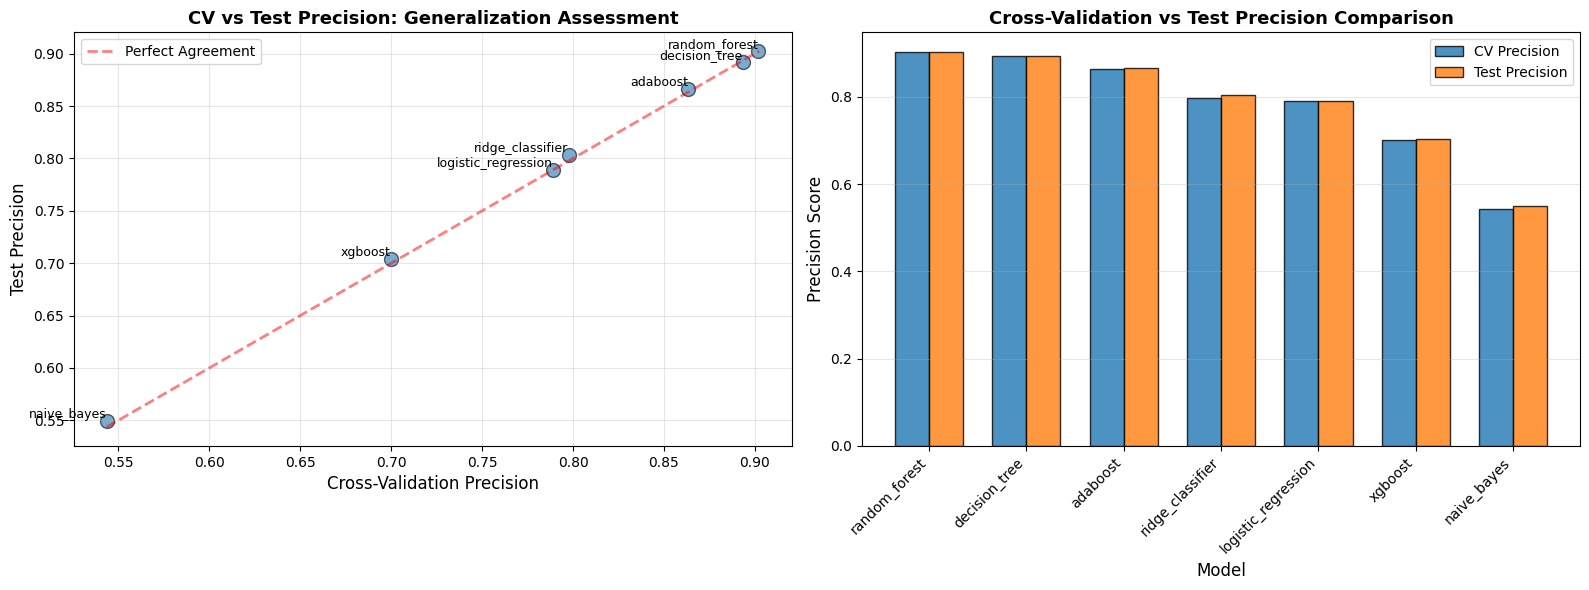

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(comparison_df['CV_Precision'], comparison_df['Test_Precision'], s=100, alpha=0.6, edgecolor='black')
for idx, row in comparison_df.iterrows():
    ax1.annotate(row['Model'], (row['CV_Precision'], row['Test_Precision']), 
                 fontsize=9, ha='right', va='bottom')
min_val = min(comparison_df['CV_Precision'].min(), comparison_df['Test_Precision'].min())
max_val = max(comparison_df['CV_Precision'].max(), comparison_df['Test_Precision'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.5, label='Perfect Agreement')
ax1.set_xlabel('Cross-Validation Precision', fontsize=12)
ax1.set_ylabel('Test Precision', fontsize=12)
ax1.set_title('CV vs Test Precision: Generalization Assessment', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

x_pos = np.arange(len(comparison_df))
width = 0.35
ax2.bar(x_pos - width/2, comparison_df['CV_Precision'], width, label='CV Precision', alpha=0.8, edgecolor='black')
ax2.bar(x_pos + width/2, comparison_df['Test_Precision'], width, label='Test Precision', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Precision Score', fontsize=12)
ax2.set_title('Cross-Validation vs Test Precision Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 6.5 Precision-Recall Trade-off Analysis

Understanding the precision-recall relationship helps evaluate whether our precision optimization excessively sacrificed recall (i.e., are we missing too many legitimate approvals?).

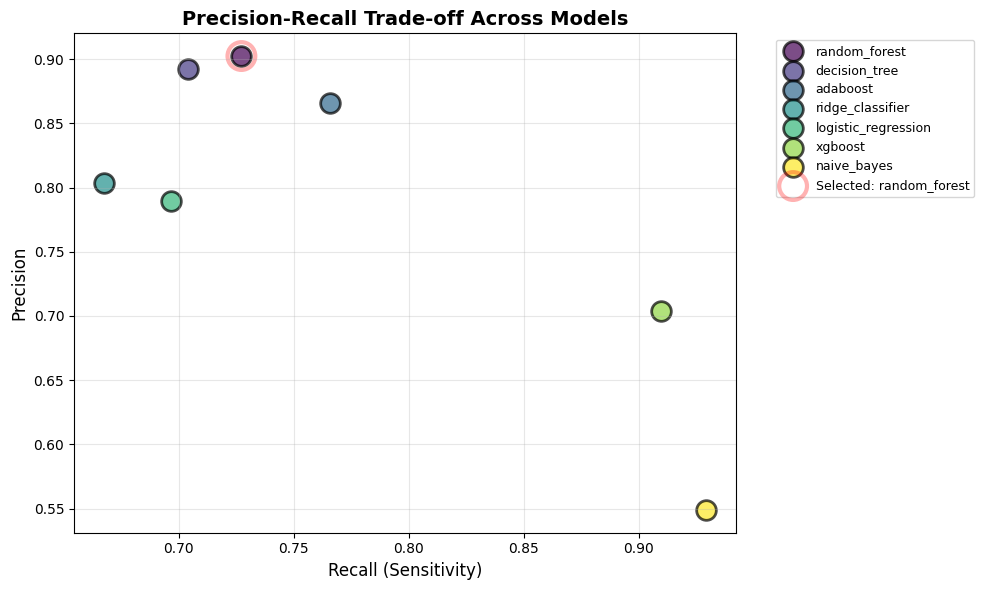


Precision-Recall Trade-off:
  Best Model (random_forest):
    Precision: 0.9024 (Primary Metric)
    Recall:    0.7273

  Interpretation:
    - Precision: 90.2% of predicted approvals match bank decisions
    - Recall: We identify 72.7% of all actual approvals


In [104]:
fig, ax = plt.subplots(figsize=(10, 6))

from matplotlib import cm
colors = cm.get_cmap('viridis')(np.linspace(0, 1, len(comparison_df)))
for idx, (_, row) in enumerate(comparison_df.iterrows()):
    ax.scatter(row['Test_Recall'], row['Test_Precision'], 
              s=200, alpha=0.7, edgecolor='black', linewidth=2,
              color=colors[idx], label=row['Model'])

best_row = comparison_df[comparison_df['Model'] == best_overall_name].iloc[0]
ax.scatter(best_row['Test_Recall'], best_row['Test_Precision'],
          s=400, alpha=0.3, edgecolor='red', linewidth=3, facecolor='none',
          label=f'Selected: {best_overall_name}')

ax.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Trade-off Across Models', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrecision-Recall Trade-off:")
print(f"  Best Model ({best_overall_name}):")
print(f"    Precision: {best_row['Test_Precision']:.4f} (Primary Metric)")
print(f"    Recall:    {best_row['Test_Recall']:.4f}")
print(f"\n  Interpretation:")
print(f"    - Precision: {best_row['Test_Precision']*100:.1f}% of predicted approvals match bank decisions")
print(f"    - Recall: We identify {best_row['Test_Recall']*100:.1f}% of all actual approvals")

In [ ]:
generalization_score = test_precision
print(f"\n{'='*70}")
print(f"FINAL GENERALIZATION SCORE (Test Precision): {generalization_score:.4f}")
print(f"{'='*70}")
print(f"\nInterpretation: When the model predicts 'approve', it matches")
print(f"the bank's decision {generalization_score*100:.2f}% of the time.")
print(f"{'='*70}")


FINAL GENERALIZATION SCORE (Test Precision): 0.9024

Interpretation: When the model predicts 'approve', it matches
the bank's decision 90.24% of the time.
